# Problem 3 (DL - MNIST)

> Reference
- https://pytorch.org/docs/stable/optim.html
- https://dejanbatanjac.github.io/2019/07/02/Impact-of-WD.html
- http://web.cs.ucla.edu/~patricia.xiao/files/CS269_Project_Report_2.pdf
- https://github.com/hunkim/PyTorchZeroToAll/blob/master/10_1_cnn_mnist.py
- https://wikidocs.net/63565

In [1]:
import torch, torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torch.optim as optimizer

import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
#  CUDA
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)

In [3]:
# Hyperparameters 
num_epochs = 20
batchSize = 4

input_dim = 784
hidden_dim = 100
hidden2_dim = 64
output_dim = 10

In [4]:
# Transformation Function
transform_to = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [5]:
# Loading the data
trainData = torchvision.datasets.MNIST(root = './data', transform = transform_to,download = True)
trainLoader = torch.utils.data.DataLoader(trainData,batch_size=batchSize,shuffle = True)

testData = torchvision.datasets.MNIST(root = './data/', transform = transform_to,train = False, download = True)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize)

In [6]:
# Visualizing a few images

def show_img(image,labels = None):
    fig = plt.figure(figsize = (10,10))
    for i in range(len(image)):
        ax = plt.subplot(1,len(image),i+1)
        unnormalized_image = image[i]*0.3081 + 0.1307
        plt.imshow(unnormalized_image, cmap = 'gray')
        plt.axis('off')
        if labels is not None:
            plt.title(labels[i])

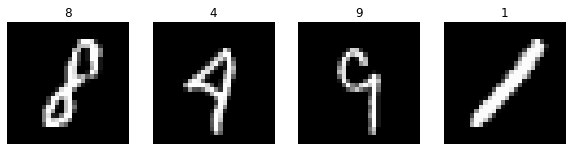

In [7]:
sample = next(iter(trainLoader))
image, label = sample
show_img(image.numpy().squeeze(),label.numpy())

In [8]:
# Defining a Network

class One_Hidden_Net(nn.Module):
    
    def __init__(self,i_dim,h_dim,o_dim):
        super().__init__()
        self.fc1 = nn.Linear(i_dim,h_dim)
        self.fc2 = nn.Linear(h_dim,o_dim)
        
    def forward(self,x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x)) # 784x100
        x = self.fc2(x) # 100x10
        return x

In [9]:
class Two_Hidden_Net(nn.Module):
    
    def __init__(self,i_dim,h1_dim,h2_dim,o_dim):
        super().__init__()
        self.fc1 = nn.Linear(i_dim,h1_dim)
        self.fc2 = nn.Linear(h1_dim,h2_dim)
        self.fc3 = nn.Linear(h2_dim,o_dim)
        

    def forward(self,x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def train(network,optimizer,loss_func):
    loss_list = []
    for epoch in range(num_epochs):
        epoch_loss = []
        for i,data in enumerate(trainLoader):
            images,label = data
            images, label = Variable(images).cuda(), Variable(label).cuda()
        
            optimizer.zero_grad()
            output = network(images)
            
            loss = loss_func(output,label)
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            

        loss_list.append(np.array(epoch_loss).mean())   
        print(f'Epoch: {epoch+1}, Loss: {np.array(epoch_loss).mean():.3f}')
    
    print('Finished Training')
    return loss_list           

In [11]:
def predict_on_test(network,iterator,model_name):
    correct = 0
    total = 0
    for data in iterator:
        images,labels = data
        images = Variable(images).cuda()
        outputs = network(images)
        class_scores,preds = torch.max(outputs.data,1)
        total += len(labels)
        correct += (preds == labels.cuda()).sum()
        
    print(f'Accuracy on Test Data using a {model_name} is {correct*100/total:.2f}%')
    
def plot_train_loss(losses,title):
    plt.plot(losses)
    plt.title(title)
    plt.xlabel('No. of Epochs')
    plt.ylabel('Training Loss')

## 3.1 One hidden layer

In [12]:
model = One_Hidden_Net(input_dim,hidden_dim,output_dim).cuda()

In [13]:
model.eval()

One_Hidden_Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [14]:
# Setting hyperparameters
loss_criterion = nn.CrossEntropyLoss()
opt = optimizer.SGD(model.parameters(),lr = 0.01)

- Training error with number of iterations

In [15]:
train_loss = train(model,opt, loss_criterion)

Epoch: 1, Loss: 0.224
Epoch: 2, Loss: 0.101
Epoch: 3, Loss: 0.072
Epoch: 4, Loss: 0.055
Epoch: 5, Loss: 0.043
Epoch: 6, Loss: 0.034
Epoch: 7, Loss: 0.028
Epoch: 8, Loss: 0.020
Epoch: 9, Loss: 0.015
Epoch: 10, Loss: 0.012
Epoch: 11, Loss: 0.009
Epoch: 12, Loss: 0.007
Epoch: 13, Loss: 0.005
Epoch: 14, Loss: 0.004
Epoch: 15, Loss: 0.003
Epoch: 16, Loss: 0.002
Epoch: 17, Loss: 0.002
Epoch: 18, Loss: 0.001
Epoch: 19, Loss: 0.001
Epoch: 20, Loss: 0.001
Finished Training


- Test error with number of iterations

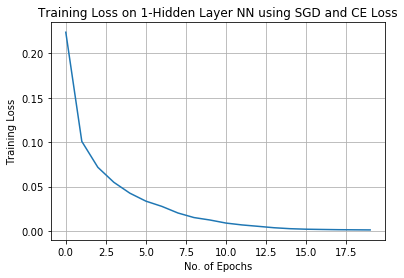

In [16]:
plot_train_loss(train_loss,'Training Loss on 1-Hidden Layer NN using SGD and CE Loss')
plt.grid(True)

In [17]:
predict_on_test(model,testLoader,'1-Hidden Layer NN')

Accuracy on Test Data using a 1-Hidden Layer NN is 98.00%


- Network architecture: Input(dim=784) - Linear(input dim=784, output dim=100) - ReLU - Linear(input dim=100, output dim=10) - Output(dim=10)
- Hyperparameters: learning rate(0.01), epochs(20), batch size(4)


## 3.2 Two hidden layers

In [18]:
model_2 = Two_Hidden_Net(input_dim,hidden2_dim,hidden2_dim,output_dim).cuda()

In [19]:
model_2.eval()

Two_Hidden_Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [20]:
num_epochs = 30

In [21]:
loss_criterion2 = nn.CrossEntropyLoss()
opt2 = optimizer.SGD(model_2.parameters(),lr = 0.01)

- Training error with iterations

In [22]:
train2_loss = train(model_2,opt2,loss_criterion2)

Epoch: 1, Loss: 0.265
Epoch: 2, Loss: 0.120
Epoch: 3, Loss: 0.086
Epoch: 4, Loss: 0.068
Epoch: 5, Loss: 0.054
Epoch: 6, Loss: 0.044
Epoch: 7, Loss: 0.038
Epoch: 8, Loss: 0.032
Epoch: 9, Loss: 0.026
Epoch: 10, Loss: 0.027
Epoch: 11, Loss: 0.021
Epoch: 12, Loss: 0.018
Epoch: 13, Loss: 0.019
Epoch: 14, Loss: 0.016
Epoch: 15, Loss: 0.015
Epoch: 16, Loss: 0.010
Epoch: 17, Loss: 0.009
Epoch: 18, Loss: 0.010
Epoch: 19, Loss: 0.008
Epoch: 20, Loss: 0.008
Epoch: 21, Loss: 0.006
Epoch: 22, Loss: 0.012
Epoch: 23, Loss: 0.009
Epoch: 24, Loss: 0.012
Epoch: 25, Loss: 0.014
Epoch: 26, Loss: 0.013
Epoch: 27, Loss: 0.009
Epoch: 28, Loss: 0.011
Epoch: 29, Loss: 0.009
Epoch: 30, Loss: 0.009
Finished Training


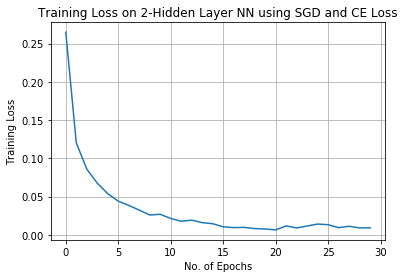

In [23]:
plt.grid(True)
plot_train_loss(train2_loss,title = 'Training Loss on 2-Hidden Layer NN using SGD and CE Loss')

- Test error with number of iterations

In [24]:
predict_on_test(model_2,testLoader,'2-Hidden Layer NN')

Accuracy on Test Data using a 2-Hidden Layer NN is 97.00%


- Comparing against the baseline: Even though I increaased the number of epochs from 20 to 30, both average and final training loss and test error with number of iterations are bigger than the baseline case.

## 3.3 Regularization and momentum

In [25]:
import torch, torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optimizer

import numpy as np
import matplotlib.pyplot as plt
import random

In [26]:
# CUDA import
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)

In [27]:
# Hyperparameters 
num_epochs = 50
batchSize = 4

input_dim = 784
hidden_dim = 100
hidden2_dim = 64
output_dim = 10

In [28]:
# Transformation Function
transform_to = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

In [29]:
# Loading the data
trainData = torchvision.datasets.MNIST(root = './data', transform = transform_to,download = True)
trainLoader = torch.utils.data.DataLoader(trainData,batch_size=batchSize,shuffle = True)

testData = torchvision.datasets.MNIST(root = './data/', transform = transform_to,train = False, download = True)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize)

In [30]:
# Defining a Network
class One_Hidden_Net(nn.Module):
    
    def __init__(self,i_dim,h_dim,o_dim):
        super().__init__()
        self.fc1 = nn.Linear(i_dim,h_dim)
        self.fc2 = nn.Linear(h_dim,o_dim)
        
    def forward(self,x):
        x = x.view(-1,784)
        x = F.relu(self.fc1(x)) # 784x100
        x = self.fc2(x) # 100x10
        return x

In [31]:
def train(network,optimizer,loss_func):
    loss_list = []
    for epoch in range(num_epochs):
        epoch_loss = []
        for i,data in enumerate(trainLoader):
            images,label = data
            images, label = Variable(images).cuda(), Variable(label).cuda()
        
            optimizer.zero_grad()
            output = network(images)
            
            loss = loss_func(output,label)
            epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()   

        loss_list.append(np.array(epoch_loss).mean())   
        print(f'Epoch: {epoch+1}, Loss: {np.array(epoch_loss).mean():.3f}')
    
    print('Finished Training')
    return loss_list           

In [32]:
def predict_on_test(network,iterator,model_name):
    correct = 0
    total = 0
    for data in iterator:
        images,labels = data
        images = Variable(images).cuda()
        outputs = network(images)
        class_scores,preds = torch.max(outputs.data,1)
        total += len(labels)
        correct += (preds == labels.cuda()).sum()
        
    print(f'Accuracy on Test Data using a {model_name} is {correct*100/total:.2f}%')
    
def plot_train_loss(losses,title):
    plt.plot(losses)
    plt.title(title)
    plt.xlabel('No. of Epochs')
    plt.ylabel('Training Loss')

In [33]:
model = One_Hidden_Net(input_dim,hidden_dim,output_dim).cuda()
model.eval()

One_Hidden_Net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [34]:
# Setting hyperparameters
loss_criterion = nn.CrossEntropyLoss()
opt = optimizer.SGD(model.parameters(),lr = 0.01, weight_decay=0.0001, momentum=0.9)

- Training loss with number of iterations

In [35]:
train_loss = train(model,opt, loss_criterion)

Epoch: 1, Loss: 0.593
Epoch: 2, Loss: 0.478
Epoch: 3, Loss: 0.461
Epoch: 4, Loss: 0.412
Epoch: 5, Loss: 0.393
Epoch: 6, Loss: 0.379
Epoch: 7, Loss: 0.361
Epoch: 8, Loss: 0.383
Epoch: 9, Loss: 0.368
Epoch: 10, Loss: 0.353
Epoch: 11, Loss: 0.380
Epoch: 12, Loss: 0.353
Epoch: 13, Loss: 0.358
Epoch: 14, Loss: 0.354
Epoch: 15, Loss: 0.339
Epoch: 16, Loss: 0.320
Epoch: 17, Loss: 0.353
Epoch: 18, Loss: 0.378
Epoch: 19, Loss: 0.377
Epoch: 20, Loss: 0.375
Epoch: 21, Loss: 0.374
Epoch: 22, Loss: 0.376
Epoch: 23, Loss: 0.362
Epoch: 24, Loss: 0.346
Epoch: 25, Loss: 0.361
Epoch: 26, Loss: 0.367
Epoch: 27, Loss: 0.322
Epoch: 28, Loss: 0.358
Epoch: 29, Loss: 0.341
Epoch: 30, Loss: 0.347
Epoch: 31, Loss: 0.372
Epoch: 32, Loss: 0.375
Epoch: 33, Loss: 0.345
Epoch: 34, Loss: 0.359
Epoch: 35, Loss: 0.338
Epoch: 36, Loss: 0.326
Epoch: 37, Loss: 0.313
Epoch: 38, Loss: 0.313
Epoch: 39, Loss: 0.336
Epoch: 40, Loss: 0.339
Epoch: 41, Loss: 0.328
Epoch: 42, Loss: 0.320
Epoch: 43, Loss: 0.361
Epoch: 44, Loss: 0.3

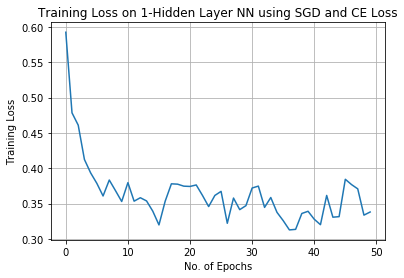

In [36]:
plot_train_loss(train_loss,'Training Loss on 1-Hidden Layer NN using SGD and CE Loss')
plt.grid(True)

- Test error with number of iterations

In [37]:
predict_on_test(model,testLoader,'1-Hidden Layer NN with Regularization and momentum')

Accuracy on Test Data using a 1-Hidden Layer NN with Regularization and momentum is 93.00%


- Here, I applied the L_2 regularization(0.0001) and momentum(0.9), with increased epochs(50) after several trying to enhance the performance. However, both training and test error with number of iterations are not enahnced. Also, it seems that the convergence speed is not shorter than the baseline, too. 

## 3.4 Convolution as hidden layers (One hidden layer)

In [38]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [39]:
# Training settings
batch_size = 64

In [40]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(),
                              download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor())

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.fc = nn.Linear(320, 10)
        
    def forward(self, x):
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1) # flatten
        x = self.fc(x)
        return F.log_softmax(x)

In [42]:
model = Net()

In [43]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)

In [44]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [45]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [46]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        
        test_loss += F.nll_loss(output, target, size_average=False).item()
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc=100. * float(correct.to(torch.device('cpu')).numpy())
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * acc / len(test_loader.dataset)))
    test_accuracy.append(acc / len(test_loader.dataset))

  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.281604
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.753450
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.591425
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.346382
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.324127
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.282812
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.272037
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.354407
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.152021
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.139856


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/conda/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  5%|▌         | 1/20 [00:48<15:16, 48.24s/it]


Test set: Average loss: 0.1823, Accuracy: 9458/10000 (9458%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.328510
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.122735
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.111271
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.177520
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.292154
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.263051
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.317642
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.192938
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.152265
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.128040


 10%|█         | 2/20 [01:35<14:25, 48.08s/it]


Test set: Average loss: 0.1324, Accuracy: 9579/10000 (9579%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.124370
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.108330
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.144034
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.092795
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.060056
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.103534
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.135712
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.053609
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.112078
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.108843


 15%|█▌        | 3/20 [02:23<13:33, 47.83s/it]


Test set: Average loss: 0.0956, Accuracy: 9716/10000 (9716%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.124013
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.031747
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.107757
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.254691
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.060665
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.103775
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.121014
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.186476
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.144312
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.058547


 20%|██        | 4/20 [03:10<12:42, 47.65s/it]


Test set: Average loss: 0.0792, Accuracy: 9753/10000 (9753%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.135017
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.039128
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.045942
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.026373
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.121497
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.061489
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.044717
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.190089
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.036976
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.076264


 25%|██▌       | 5/20 [03:57<11:53, 47.58s/it]


Test set: Average loss: 0.0734, Accuracy: 9769/10000 (9769%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.056796
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.099275
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.083085
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.031062
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.065880
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.087365
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.016613
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.043000
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.016091
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.146933


 30%|███       | 6/20 [04:43<10:59, 47.12s/it]


Test set: Average loss: 0.0697, Accuracy: 9795/10000 (9795%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.073106
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.132394
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.040504
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.112899
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.115839
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.070053
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.028354
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.070449
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.029718
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.028352


 35%|███▌      | 7/20 [05:29<10:08, 46.79s/it]


Test set: Average loss: 0.0651, Accuracy: 9809/10000 (9809%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.055644
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.053320
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.192674
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.011993
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.012935
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.042930
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.033069
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.186983
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.022013
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.044081


 40%|████      | 8/20 [06:18<09:26, 47.19s/it]


Test set: Average loss: 0.0611, Accuracy: 9811/10000 (9811%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.008385
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.090705
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.053843
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.113755
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.014340
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.064048
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.107042
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.059895
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.029288
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.122575


 45%|████▌     | 9/20 [07:05<08:38, 47.17s/it]


Test set: Average loss: 0.0568, Accuracy: 9821/10000 (9821%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.042346
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.016629
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.014050
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.057512
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.006512
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.086876
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.014761
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.022723
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.047865
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.018898


 50%|█████     | 10/20 [07:51<07:50, 47.01s/it]


Test set: Average loss: 0.0577, Accuracy: 9807/10000 (9807%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.068650
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.020694
Train Epoch: 11 [12800/60000 (21%)]	Loss: 0.109411
Train Epoch: 11 [19200/60000 (32%)]	Loss: 0.068682
Train Epoch: 11 [25600/60000 (43%)]	Loss: 0.012919
Train Epoch: 11 [32000/60000 (53%)]	Loss: 0.053391
Train Epoch: 11 [38400/60000 (64%)]	Loss: 0.025951
Train Epoch: 11 [44800/60000 (75%)]	Loss: 0.069147
Train Epoch: 11 [51200/60000 (85%)]	Loss: 0.021946
Train Epoch: 11 [57600/60000 (96%)]	Loss: 0.052625


 55%|█████▌    | 11/20 [08:38<07:01, 46.86s/it]


Test set: Average loss: 0.0511, Accuracy: 9848/10000 (9848%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.005838
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.064544
Train Epoch: 12 [12800/60000 (21%)]	Loss: 0.061974
Train Epoch: 12 [19200/60000 (32%)]	Loss: 0.013750
Train Epoch: 12 [25600/60000 (43%)]	Loss: 0.043231
Train Epoch: 12 [32000/60000 (53%)]	Loss: 0.030093
Train Epoch: 12 [38400/60000 (64%)]	Loss: 0.119869
Train Epoch: 12 [44800/60000 (75%)]	Loss: 0.087667
Train Epoch: 12 [51200/60000 (85%)]	Loss: 0.026439
Train Epoch: 12 [57600/60000 (96%)]	Loss: 0.038113


 60%|██████    | 12/20 [09:25<06:14, 46.85s/it]


Test set: Average loss: 0.0463, Accuracy: 9854/10000 (9854%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.030080
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.012866
Train Epoch: 13 [12800/60000 (21%)]	Loss: 0.050546
Train Epoch: 13 [19200/60000 (32%)]	Loss: 0.048703
Train Epoch: 13 [25600/60000 (43%)]	Loss: 0.027932
Train Epoch: 13 [32000/60000 (53%)]	Loss: 0.048167
Train Epoch: 13 [38400/60000 (64%)]	Loss: 0.035738
Train Epoch: 13 [44800/60000 (75%)]	Loss: 0.093581
Train Epoch: 13 [51200/60000 (85%)]	Loss: 0.022314
Train Epoch: 13 [57600/60000 (96%)]	Loss: 0.019012


 65%|██████▌   | 13/20 [10:11<05:27, 46.74s/it]


Test set: Average loss: 0.0486, Accuracy: 9850/10000 (9850%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.012633
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.020600
Train Epoch: 14 [12800/60000 (21%)]	Loss: 0.015533
Train Epoch: 14 [19200/60000 (32%)]	Loss: 0.034315
Train Epoch: 14 [25600/60000 (43%)]	Loss: 0.018703
Train Epoch: 14 [32000/60000 (53%)]	Loss: 0.087834
Train Epoch: 14 [38400/60000 (64%)]	Loss: 0.094213
Train Epoch: 14 [44800/60000 (75%)]	Loss: 0.035986
Train Epoch: 14 [51200/60000 (85%)]	Loss: 0.019165
Train Epoch: 14 [57600/60000 (96%)]	Loss: 0.017370


 70%|███████   | 14/20 [10:58<04:40, 46.67s/it]


Test set: Average loss: 0.0442, Accuracy: 9857/10000 (9857%)

Train Epoch: 15 [0/60000 (0%)]	Loss: 0.048000
Train Epoch: 15 [6400/60000 (11%)]	Loss: 0.012079
Train Epoch: 15 [12800/60000 (21%)]	Loss: 0.029104
Train Epoch: 15 [19200/60000 (32%)]	Loss: 0.041176
Train Epoch: 15 [25600/60000 (43%)]	Loss: 0.026378
Train Epoch: 15 [32000/60000 (53%)]	Loss: 0.072891
Train Epoch: 15 [38400/60000 (64%)]	Loss: 0.017140
Train Epoch: 15 [44800/60000 (75%)]	Loss: 0.090922
Train Epoch: 15 [51200/60000 (85%)]	Loss: 0.171032
Train Epoch: 15 [57600/60000 (96%)]	Loss: 0.077376


 75%|███████▌  | 15/20 [11:44<03:53, 46.69s/it]


Test set: Average loss: 0.0462, Accuracy: 9864/10000 (9864%)

Train Epoch: 16 [0/60000 (0%)]	Loss: 0.100887
Train Epoch: 16 [6400/60000 (11%)]	Loss: 0.035004
Train Epoch: 16 [12800/60000 (21%)]	Loss: 0.106131
Train Epoch: 16 [19200/60000 (32%)]	Loss: 0.024153
Train Epoch: 16 [25600/60000 (43%)]	Loss: 0.106754
Train Epoch: 16 [32000/60000 (53%)]	Loss: 0.027814
Train Epoch: 16 [38400/60000 (64%)]	Loss: 0.021185
Train Epoch: 16 [44800/60000 (75%)]	Loss: 0.057463
Train Epoch: 16 [51200/60000 (85%)]	Loss: 0.075510
Train Epoch: 16 [57600/60000 (96%)]	Loss: 0.073660


 80%|████████  | 16/20 [12:32<03:07, 46.87s/it]


Test set: Average loss: 0.0434, Accuracy: 9864/10000 (9864%)

Train Epoch: 17 [0/60000 (0%)]	Loss: 0.028010
Train Epoch: 17 [6400/60000 (11%)]	Loss: 0.018243
Train Epoch: 17 [12800/60000 (21%)]	Loss: 0.010874
Train Epoch: 17 [19200/60000 (32%)]	Loss: 0.031479
Train Epoch: 17 [25600/60000 (43%)]	Loss: 0.045656
Train Epoch: 17 [32000/60000 (53%)]	Loss: 0.076763
Train Epoch: 17 [38400/60000 (64%)]	Loss: 0.046244
Train Epoch: 17 [44800/60000 (75%)]	Loss: 0.009240
Train Epoch: 17 [51200/60000 (85%)]	Loss: 0.026695
Train Epoch: 17 [57600/60000 (96%)]	Loss: 0.002260


 85%|████████▌ | 17/20 [13:18<02:20, 46.69s/it]


Test set: Average loss: 0.0472, Accuracy: 9844/10000 (9844%)

Train Epoch: 18 [0/60000 (0%)]	Loss: 0.041418
Train Epoch: 18 [6400/60000 (11%)]	Loss: 0.047464
Train Epoch: 18 [12800/60000 (21%)]	Loss: 0.006182
Train Epoch: 18 [19200/60000 (32%)]	Loss: 0.113613
Train Epoch: 18 [25600/60000 (43%)]	Loss: 0.025447
Train Epoch: 18 [32000/60000 (53%)]	Loss: 0.013436
Train Epoch: 18 [38400/60000 (64%)]	Loss: 0.019173
Train Epoch: 18 [44800/60000 (75%)]	Loss: 0.015538
Train Epoch: 18 [51200/60000 (85%)]	Loss: 0.040583
Train Epoch: 18 [57600/60000 (96%)]	Loss: 0.156350


 90%|█████████ | 18/20 [14:04<01:32, 46.44s/it]


Test set: Average loss: 0.0486, Accuracy: 9842/10000 (9842%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 0.005449
Train Epoch: 19 [6400/60000 (11%)]	Loss: 0.033868
Train Epoch: 19 [12800/60000 (21%)]	Loss: 0.026057
Train Epoch: 19 [19200/60000 (32%)]	Loss: 0.059282
Train Epoch: 19 [25600/60000 (43%)]	Loss: 0.022270
Train Epoch: 19 [32000/60000 (53%)]	Loss: 0.066404
Train Epoch: 19 [38400/60000 (64%)]	Loss: 0.051747
Train Epoch: 19 [44800/60000 (75%)]	Loss: 0.044481
Train Epoch: 19 [51200/60000 (85%)]	Loss: 0.016437
Train Epoch: 19 [57600/60000 (96%)]	Loss: 0.004512


 95%|█████████▌| 19/20 [14:52<00:46, 46.89s/it]


Test set: Average loss: 0.0452, Accuracy: 9849/10000 (9849%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 0.035284
Train Epoch: 20 [6400/60000 (11%)]	Loss: 0.012196
Train Epoch: 20 [12800/60000 (21%)]	Loss: 0.012385
Train Epoch: 20 [19200/60000 (32%)]	Loss: 0.014966
Train Epoch: 20 [25600/60000 (43%)]	Loss: 0.069989
Train Epoch: 20 [32000/60000 (53%)]	Loss: 0.014589
Train Epoch: 20 [38400/60000 (64%)]	Loss: 0.015002
Train Epoch: 20 [44800/60000 (75%)]	Loss: 0.008982
Train Epoch: 20 [51200/60000 (85%)]	Loss: 0.054384
Train Epoch: 20 [57600/60000 (96%)]	Loss: 0.059584


100%|██████████| 20/20 [15:39<00:00, 46.87s/it]


Test set: Average loss: 0.0480, Accuracy: 9846/10000 (9846%)



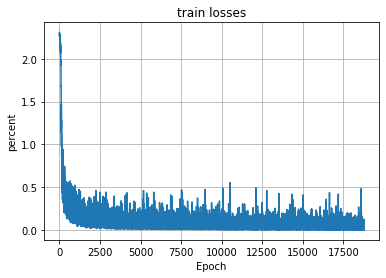

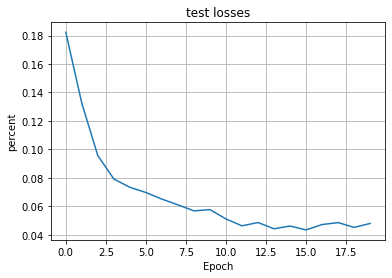

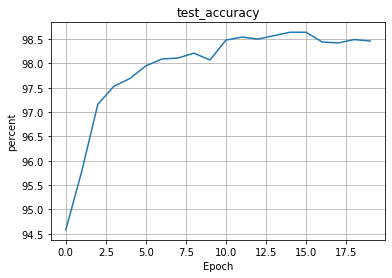

In [47]:
train_losses = []
test_losses =[]
test_accuracy = []

from tqdm import tqdm
for epoch in tqdm(range(1, 21)):
    train(epoch)
    test()
    
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.grid(True)

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.grid(True)

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.grid(True)

- Both training and test error with iterations are getting slightly enhanced. 

## 3.4 Different network architecture - LeNet

In [48]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [49]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root='./data', train=True, transform=trans, download=True)
test_set = dset.MNIST(root='./data', train=False, transform=trans)
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

In [50]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [51]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('\rEpoch: {} {:.0f}%\t     Loss: {:.6f}'.format(
                epoch,
                100. * batch_idx / len(train_loader), loss.item()), end='')

In [52]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum() 
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc=100. * float(correct.to(torch.device('cpu')).numpy())
    print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
        test_loss, acc / len(test_loader.dataset)))
    
    test_accuracy.append(acc / len(test_loader.dataset))


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 96%	     Loss: 0.560400

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
  3%|▎         | 1/30 [00:19<09:32, 19.74s/it]


Test result: Average loss: 0.3585, Accuracy: 89.9800%

Epoch: 2 96%	     Loss: 0.192723

  7%|▋         | 2/30 [00:39<09:13, 19.76s/it]


Test result: Average loss: 0.2097, Accuracy: 93.4100%

Epoch: 3 96%	     Loss: 0.544508

 10%|█         | 3/30 [00:59<08:57, 19.90s/it]


Test result: Average loss: 0.1622, Accuracy: 94.9100%

Epoch: 4 96%	     Loss: 0.576473

 13%|█▎        | 4/30 [01:19<08:38, 19.95s/it]


Test result: Average loss: 0.1327, Accuracy: 95.9700%

Epoch: 5 96%	     Loss: 0.266748

 17%|█▋        | 5/30 [01:39<08:17, 19.88s/it]


Test result: Average loss: 0.1130, Accuracy: 96.3900%

Epoch: 6 96%	     Loss: 0.152597

 20%|██        | 6/30 [02:00<08:02, 20.10s/it]


Test result: Average loss: 0.0992, Accuracy: 96.8400%

Epoch: 7 96%	     Loss: 0.444732

 23%|██▎       | 7/30 [02:19<07:38, 19.93s/it]


Test result: Average loss: 0.0918, Accuracy: 97.1000%

Epoch: 8 96%	     Loss: 0.255403

 27%|██▋       | 8/30 [02:39<07:19, 19.96s/it]


Test result: Average loss: 0.0854, Accuracy: 97.2100%

Epoch: 9 96%	     Loss: 0.123484

 30%|███       | 9/30 [02:58<06:54, 19.74s/it]


Test result: Average loss: 0.0804, Accuracy: 97.5400%

Epoch: 10 96%	     Loss: 0.418725

 33%|███▎      | 10/30 [03:17<06:29, 19.46s/it]


Test result: Average loss: 0.0771, Accuracy: 97.5800%

Epoch: 11 96%	     Loss: 0.210911

 37%|███▋      | 11/30 [03:35<06:02, 19.08s/it]


Test result: Average loss: 0.0697, Accuracy: 97.7900%

Epoch: 12 96%	     Loss: 0.540525

 40%|████      | 12/30 [03:54<05:40, 18.90s/it]


Test result: Average loss: 0.0663, Accuracy: 97.8200%

Epoch: 13 96%	     Loss: 0.354333

 43%|████▎     | 13/30 [04:13<05:21, 18.91s/it]


Test result: Average loss: 0.0629, Accuracy: 97.9700%

Epoch: 14 96%	     Loss: 0.256937

 47%|████▋     | 14/30 [04:32<05:01, 18.85s/it]


Test result: Average loss: 0.0632, Accuracy: 97.9800%

Epoch: 15 96%	     Loss: 0.069305

 50%|█████     | 15/30 [04:50<04:40, 18.69s/it]


Test result: Average loss: 0.0601, Accuracy: 98.0500%

Epoch: 16 96%	     Loss: 0.069799

 53%|█████▎    | 16/30 [05:08<04:20, 18.61s/it]


Test result: Average loss: 0.0578, Accuracy: 98.0400%

Epoch: 17 96%	     Loss: 0.135962

 57%|█████▋    | 17/30 [05:27<04:02, 18.66s/it]


Test result: Average loss: 0.0552, Accuracy: 98.3000%

Epoch: 18 96%	     Loss: 0.076777

 60%|██████    | 18/30 [05:45<03:42, 18.53s/it]


Test result: Average loss: 0.0550, Accuracy: 98.2400%

Epoch: 19 96%	     Loss: 0.136008

 63%|██████▎   | 19/30 [06:02<03:18, 18.09s/it]


Test result: Average loss: 0.0524, Accuracy: 98.4200%

Epoch: 20 96%	     Loss: 0.118022

 67%|██████▋   | 20/30 [06:20<02:59, 17.97s/it]


Test result: Average loss: 0.0517, Accuracy: 98.4200%

Epoch: 21 96%	     Loss: 0.176764

 70%|███████   | 21/30 [06:39<02:43, 18.22s/it]


Test result: Average loss: 0.0493, Accuracy: 98.4600%

Epoch: 22 96%	     Loss: 0.108407

 73%|███████▎  | 22/30 [06:57<02:25, 18.16s/it]


Test result: Average loss: 0.0483, Accuracy: 98.4600%

Epoch: 23 96%	     Loss: 0.087305

 77%|███████▋  | 23/30 [07:15<02:06, 18.06s/it]


Test result: Average loss: 0.0501, Accuracy: 98.5000%

Epoch: 24 96%	     Loss: 0.299701

 80%|████████  | 24/30 [07:33<01:49, 18.23s/it]


Test result: Average loss: 0.0460, Accuracy: 98.5500%

Epoch: 25 96%	     Loss: 0.122734

 83%|████████▎ | 25/30 [07:52<01:31, 18.30s/it]


Test result: Average loss: 0.0463, Accuracy: 98.5600%

Epoch: 26 96%	     Loss: 0.131053

 87%|████████▋ | 26/30 [08:09<01:12, 18.12s/it]


Test result: Average loss: 0.0432, Accuracy: 98.6100%

Epoch: 27 96%	     Loss: 0.221591

 90%|█████████ | 27/30 [08:27<00:54, 18.07s/it]


Test result: Average loss: 0.0440, Accuracy: 98.5400%

Epoch: 28 96%	     Loss: 0.056607

 93%|█████████▎| 28/30 [08:45<00:35, 17.99s/it]


Test result: Average loss: 0.0410, Accuracy: 98.6400%

Epoch: 29 96%	     Loss: 0.230886

 97%|█████████▋| 29/30 [09:04<00:18, 18.27s/it]


Test result: Average loss: 0.0436, Accuracy: 98.5200%

Epoch: 30 96%	     Loss: 0.085373

100%|██████████| 30/30 [09:22<00:00, 18.19s/it]


Test result: Average loss: 0.0403, Accuracy: 98.6200%



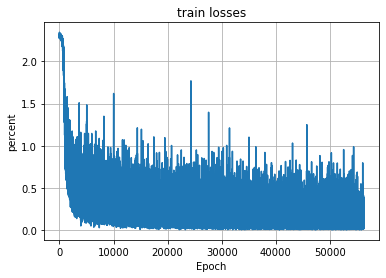

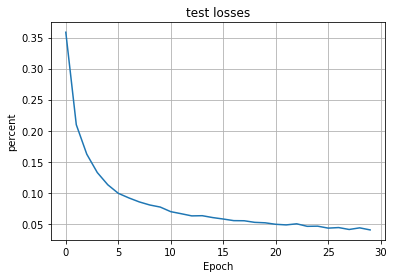

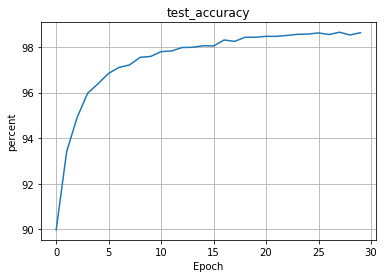

In [53]:
model = LeNet()
if torch.cuda.is_available():
    model.cuda()
        
optimizer = optim.SGD(model.parameters(), lr=0.01) #0.0001

train_losses = []
test_losses =[]
test_accuracy = []
for epoch in tqdm(range(1, 31)):
    train(epoch)
    test()
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.grid(True)

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.grid(True)

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.grid(True)

- The LeNet could be considered as almost same level of performance as the baseline, but the convergence speed is slower and small fluctuation is observed. 

## 3.4 Different network architecture - AlexNet

In [54]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [55]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root='./data', train=True, transform=trans, download=True)
test_set = dset.MNIST(root='./data', train=False, transform=trans)
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

In [56]:
class AlexNet(nn.Module):   
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True), 
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),   
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),                         
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*12*12,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),
         
        )
    
    def forward(self, x):

        x = self.feature(x)
        x = x.view(-1,32*12*12)
        x = self.classifier(x)
        return x

In [57]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('\rEpoch: {} {:.0f}%\t     Loss: {:.6f}'.format(
                epoch,
                100. * batch_idx / len(train_loader), loss.item()), end='')

In [58]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
      
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc=100. * float(correct.to(torch.device('cpu')).numpy())
    print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
        test_loss, acc / len(test_loader.dataset)))
    
    test_accuracy.append(acc / len(test_loader.dataset))

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 96%	     Loss: 2.295179

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
  7%|▋         | 1/15 [00:21<04:56, 21.21s/it]


Test result: Average loss: 2.2999, Accuracy: 11.3500%

Epoch: 2 96%	     Loss: 0.991831

 13%|█▎        | 2/15 [00:42<04:34, 21.15s/it]


Test result: Average loss: 0.6118, Accuracy: 78.0400%

Epoch: 3 96%	     Loss: 0.362625

 20%|██        | 3/15 [01:04<04:16, 21.35s/it]


Test result: Average loss: 0.1439, Accuracy: 95.2100%

Epoch: 4 96%	     Loss: 0.225174

 27%|██▋       | 4/15 [01:25<03:55, 21.41s/it]


Test result: Average loss: 0.0839, Accuracy: 97.1700%

Epoch: 5 96%	     Loss: 0.027573

 33%|███▎      | 5/15 [01:47<03:36, 21.63s/it]


Test result: Average loss: 0.0641, Accuracy: 97.7500%

Epoch: 6 96%	     Loss: 0.112189

 40%|████      | 6/15 [02:08<03:13, 21.52s/it]


Test result: Average loss: 0.0579, Accuracy: 98.0700%

Epoch: 7 96%	     Loss: 0.029149

 47%|████▋     | 7/15 [02:31<02:53, 21.69s/it]


Test result: Average loss: 0.0491, Accuracy: 98.2900%

Epoch: 8 96%	     Loss: 0.031573

 53%|█████▎    | 8/15 [02:52<02:30, 21.50s/it]


Test result: Average loss: 0.0436, Accuracy: 98.6900%

Epoch: 9 96%	     Loss: 0.027656

 60%|██████    | 9/15 [03:13<02:09, 21.55s/it]


Test result: Average loss: 0.0392, Accuracy: 98.7800%

Epoch: 10 96%	     Loss: 0.002755

 67%|██████▋   | 10/15 [03:34<01:46, 21.35s/it]


Test result: Average loss: 0.0323, Accuracy: 98.9200%

Epoch: 11 96%	     Loss: 0.030650

 73%|███████▎  | 11/15 [03:55<01:25, 21.34s/it]


Test result: Average loss: 0.0321, Accuracy: 98.8800%

Epoch: 12 96%	     Loss: 0.007204

 80%|████████  | 12/15 [04:16<01:03, 21.04s/it]


Test result: Average loss: 0.0281, Accuracy: 98.9800%

Epoch: 13 96%	     Loss: 0.078330

 87%|████████▋ | 13/15 [04:37<00:42, 21.19s/it]


Test result: Average loss: 0.0304, Accuracy: 98.9200%

Epoch: 14 96%	     Loss: 0.001200

 93%|█████████▎| 14/15 [04:59<00:21, 21.30s/it]


Test result: Average loss: 0.0276, Accuracy: 99.1100%

Epoch: 15 96%	     Loss: 0.013864

100%|██████████| 15/15 [05:20<00:00, 21.32s/it]


Test result: Average loss: 0.0265, Accuracy: 99.0500%



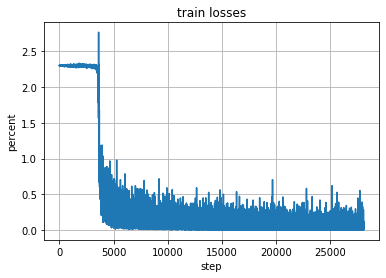

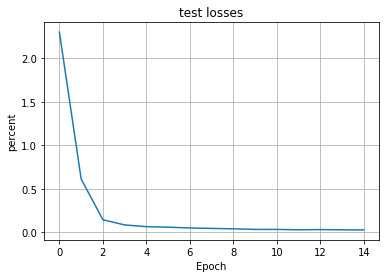

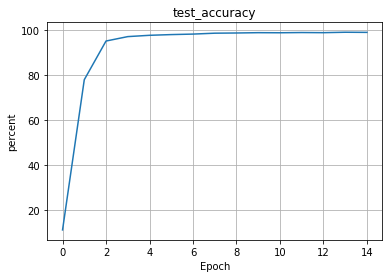

In [59]:
model = AlexNet()
if torch.cuda.is_available():
    model.cuda()
        
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_losses = []
test_losses =[]
test_accuracy = []
for epoch in tqdm(range(1, 16)):
    train(epoch)
    test()
    
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('step')
plt.ylabel('percent')
plt.grid(True)

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.grid(True)

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('percent')
plt.grid(True)

- AlexNet is showing the best performance among tested models. In only 15 epochs, it showed over the 99% on the test accuracy within early few epochs, and the fluctuation is much smaller than others. 